# processing - new format

The datastream includes both data and features for every recorded samples.

In [12]:
import plotly.express as px

In [1]:
from nbimports import *

In [2]:
import processing
processing = reload(processing)

In [3]:
filename = "../data/user/data_29042022_180743.csv"

In [4]:
data = pd.read_csv(filename, index_col=0)
data.columns = ['source', 'data']

In [5]:
new_rows = []
default_value = np.ones(3) * np.nan

for i, row in data.iterrows():
    row = eval(row['data'].replace("false", "False"))

    key = row['sample_key']
    t0 = row['timestamp0']
    ts = row['timestamp']
    stroke_id = row['stroke_id']
    segment_id = row['segment_id']

    x, y, p = row.get('xyp', default_value)
    x_, y_, p_ = row.get('rel_xyp', default_value)
    x0, y0, p0 = row.get('rel_xyp_lp', default_value)
    x1, y1, p1 = row.get('xyp_sg', default_value)
    s = row['s']
    da = row['da']
    da = da[0] if isinstance(da, (list,)) else da
    
    new_row = [key, t0, ts, stroke_id, segment_id, x, y, p, x_, y_, p_, x0, y0, p0, x1, y1, p1, s, da]
    new_rows.append(new_row)

data_df = pd.DataFrame(data=new_rows, 
                    columns=['key', 't0', 'ts',
                             'stroke_id', 'segment_id',
                             'x', 'y', 'p', 'x_', 'y_', 'p_', 
                             'x0', 'y0', 'p0', 'x1', 'y1', 'p1',
                             's', 'da']
                   )

## figure all

In [9]:
data_df.head()

,key,t0,ts,stroke_id,segment_id,x,y,p,x_,y_,p_,x0,y0,p0,x1,y1,p1,s,da
0,3587199_50,3587199,50,8,0,0.345268,0.749269,0.022725,-0.006020,0.001405,0.000566,-0.000137,0.000054,-0.000137,-0.000052,0.000020,-0.000038,0.005605,0.0
1,3587212_60,3587212,60,8,0,0.339485,0.747847,0.022137,-0.011803,-0.000016,-0.000022,-0.000386,0.000144,-0.000244,-0.000127,0.000044,-0.000059,0.013457,0.0
2,3587225_70,3587225,70,8,0,0.331856,0.745303,0.021224,-0.019432,-0.002561,-0.000935,-0.000886,0.000298,-0.000351,-0.000264,0.000079,-0.000074,0.027557,0.0
3,3587225_80,3587225,80,8,0,0.326874,0.742462,0.021136,-0.024414,-0.005402,-0.001023,-0.001761,0.000501,-0.000413,-0.000488,0.000115,-0.000074,0.050165,0.0
4,3587238_90,3587238,90,8,0,0.321669,0.738565,0.019913,-0.029620,-0.009298,-0.002247,-0.003164,0.000673,-0.000406,-0.000828,0.000127,-0.000056,0.083717,0.0


<AxesSubplot:xlabel='x', ylabel='y'>

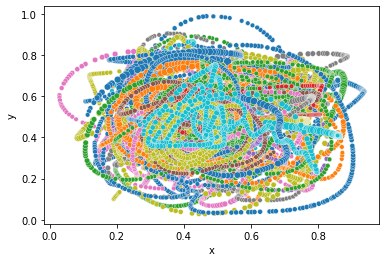

In [10]:
sns.scatterplot(data=data_df, x='x', y='y', size='p', hue='stroke_id', palette='tab10', legend=False)

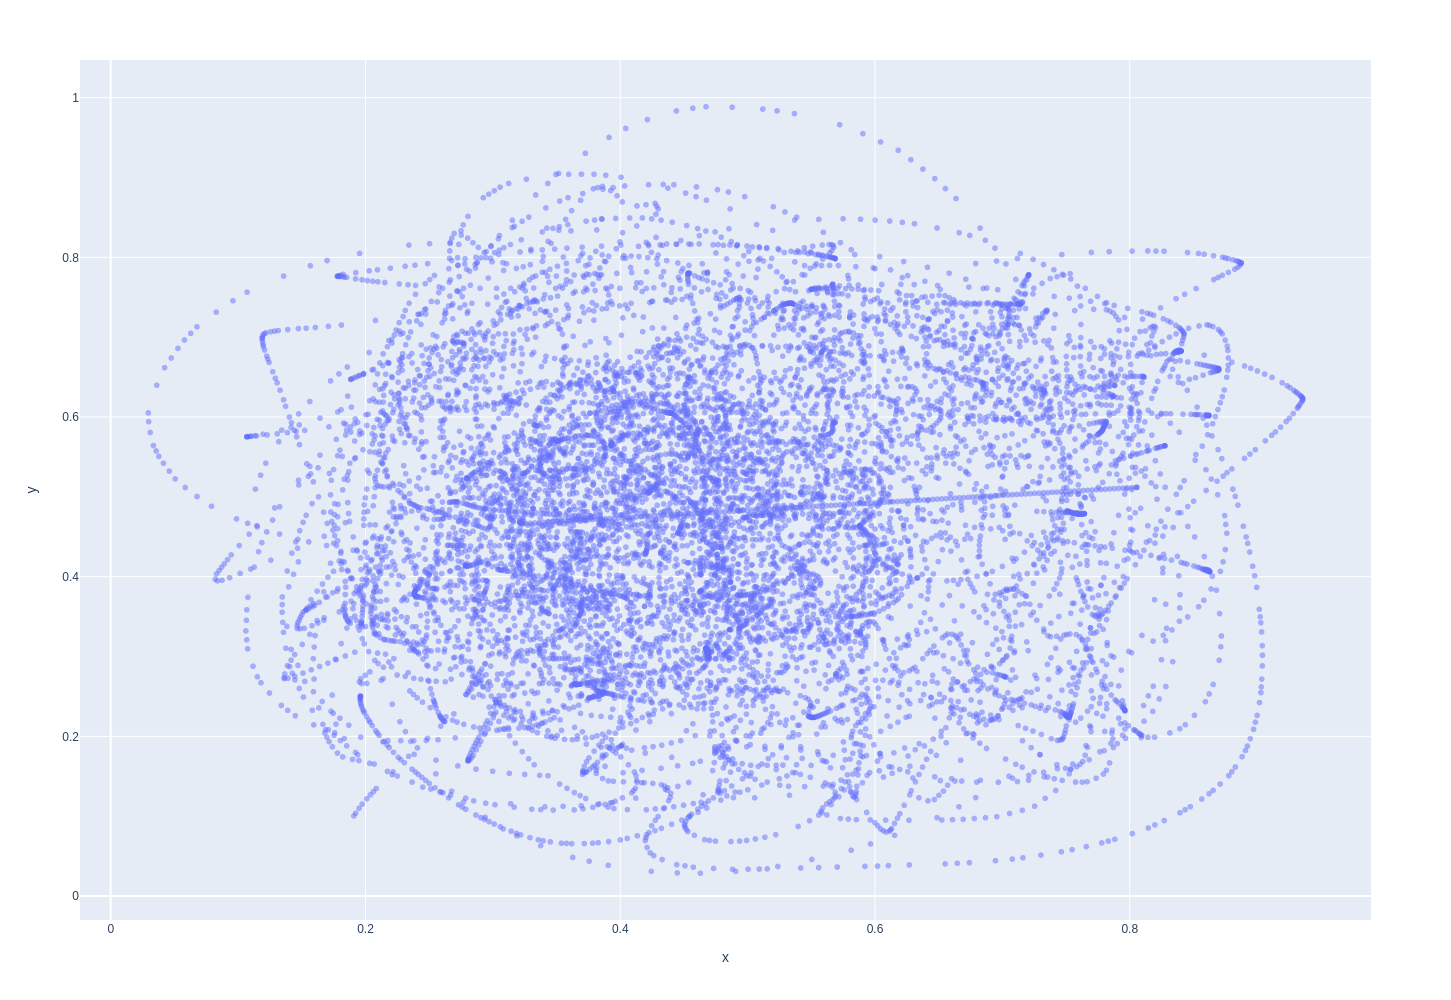

In [16]:
fig = px.scatter(x=data_df['x'], y=data_df['y'], opacity=0.5)
fig.layout.update(showlegend=False,
                  autosize=False,
                  width=1000,
                  height=1000,)
fig

## figure segments

In [20]:
import plotly.graph_objects as go

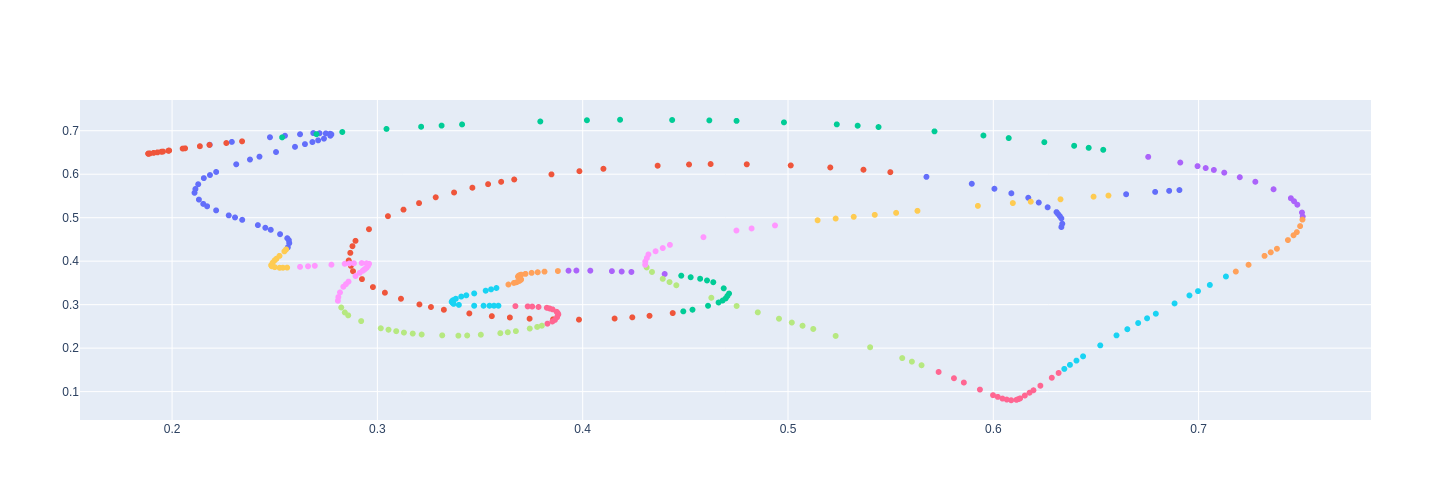

In [21]:
# select stroke
stroke_i = select(data_df, stroke_id=9)

if stroke_i.shape[0] > 0:
    # stroke_i_feat = stroke_i.join(df.set_index('key'), on='key').dropna()
    # if stroke_i_feat.shape[0] > 0:
    # p_scaled = mms.transform(stroke_i['p'].values.reshape(-1,1)).reshape(-1)
    colors = ["rgba"+str(tab10[int(i)%10]+(1,)) for i in stroke_i['segment_id']]
    fig = px.scatter(x=stroke_i['x'], y=stroke_i['y'], color=colors)

fig = go.Figure(data=fig.data)
fig.layout.update(
    showlegend=False,
    autosize=False,
    width=500,
    height=500,
)
fig

## clusterisation

In [22]:
segments = [grp[['s', 'da']].values for i, grp in data_df.groupby('segment_id')]

In [24]:
import clusterisation

In [11]:
sm_seg = clusterisation.compute_similarity_matrix(segments)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 12304 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 173166 out of 173166 | elapsed:    8.6s finished


In [12]:
import warnings

In [15]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    emb_seg = clusterisation.tsne_embed(sm_seg, perplexity=30) 

===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 2.6790, 50 iterations in 0.5268 sec
Iteration  100, KL divergence 2.6615, 50 iterations in 0.5566 sec
Iteration  150, KL divergence 2.6538, 50 iterations in 0.5460 sec
Iteration  200, KL divergence 2.6467, 50 iterations in 0.5191 sec
Iteration  250, KL divergence 2.6407, 50 iterations in 0.5195 sec
   --> Time elapsed: 2.67 seconds
CPU times: user 1min 41s, sys: 1.92 s, total: 1min 43s
Wall time: 14.9 s


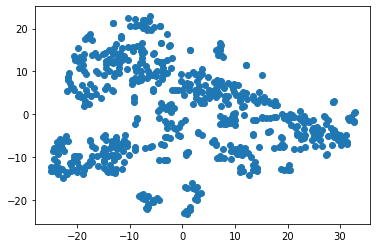

/Users/aloriette/opt/anaconda3/envs/rto_nime22/lib/python3.7/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
/Users/aloriette/opt/anaconda3/envs/rto_nime22/lib/python3.7/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
/Users/aloriette/opt/anaconda3/envs/rto_nime22/lib/python3.7/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
/Users/aloriette/opt/anaconda3/envs/rto_nime22/lib/python3.7/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
/Users/aloriette

In [16]:
plt.scatter(emb_seg[:, 0], emb_seg[:, 1])